In [92]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pickle
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import rankdata
import scipy
from nilearn import datasets, image, plotting
import mne

In [2]:
id_eleccount = # Removed to protect patient anonymity

In [137]:
signif_electrode_dict = pickle.load(open("../../derivatives/results/word-onsets/signif_elec_dict.pkl", "rb"))

In [4]:
def segment_transcript_by_movie(patient_id, ecog1_t, ecog2_t):
    # Load in interview transcript
    with open('/scratch/gpfs/mayaar/GravityECoG/sourcedata/interview-transcripts/cleaned/cleaned_transcript_ny' + patient_id + '.csv', newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        
    # Movie 1
    onsets_1 = []
    # Movie 2
    onsets_2 = []

    # Check if word recorded during first or second ECoG recording
    # Do not include words said in first or last 2000ms of either recording (out of sliding time window range)
    for i in range(len(data)):
        if ((float(data[i][2]) > (ecog1_t[0] + 2)) and (float(data[i][2]) < (ecog1_t[-1] - 2))):
            onsets_1.append(data[i][2])
        if ((float(data[i][2]) > (ecog2_t[0] + 2)) and (float(data[i][2]) < (ecog2_t[-1] - 2))):
            onsets_2.append(data[i][2])

    onsets_1 = np.array(onsets_1, dtype=float)
    onsets_2 = np.array(onsets_2, dtype=float)
    
    return onsets_1, onsets_2

In [5]:
def get_ecog_index_of_onset(word_onset, ecog_time_axis):
    # calculate the difference array
    difference_array = np.absolute(ecog_time_axis-word_onset)

    # find the index of minimum element from the array
    index = difference_array.argmin()
    
    return index

In [6]:
def get_ecog_idxs(onsets, ecog, ecog_t):
    grav_idxs = np.zeros(len(onsets))

    for i in range(len(onsets)):
        grav_idxs[i] = get_ecog_index_of_onset(onsets[i], ecog_t)
        
    return grav_idxs

In [7]:
# For each electrode, average signal value with two nearest signal points before + after it
def get_average_ecog_val_at_idx(index, ecog_data):
    return np.mean(ecog_data[:, index-2:index+3], axis=1)

In [8]:
def get_ecog_vals_at_word_onsets(onsets, ecog, grav_idxs, time_slide):
    ecog_vals_at_word_onsets = np.zeros((len(onsets), ecog.shape[0]))
    
    for i in range(len(onsets)):
        idx = int(grav_idxs[i] + time_slide)
        ecog_vals_at_word_onsets[i, :] = get_average_ecog_val_at_idx(idx, ecog)
    
    return ecog_vals_at_word_onsets

In [9]:
def reg_pred_ecog_corr(embeddings1, embeddings2, ecog1, ecog2):
    # full_emb = np.concatenate((embeddings1, embeddings2), axis=0)
    # full_ecog = np.concatenate((ecog1, ecog2), axis=0)

    # x_train, x_test, y_train, y_test = train_test_split(full_emb, full_ecog, test_size=0.1)
    reg = LinearRegression().fit(embeddings1, ecog1)
    # return r2_score(y_test, reg.predict(x_test))
    return stats.pearsonr(ecog2, reg.predict(embeddings2))

## GloVe Regression

In [ ]:
# 2000ms sliding time window (2000ms before/after word onset) 
# (100 points / 1 s) * (1 s / 1000 ms) =  0.1 points/ms * 2000ms = 200 points
# 200 * 2 + 1 = 401 point window

for patient_id in id_eleccount:
    print(patient_id)
    # Load GloVe embeddings
    ge_1 = rankdata(np.load("glove_emb_1_" + patient_id + ".npy", allow_pickle=True), axis=1)
    ge_2 = rankdata(np.load("glove_emb_2_" + patient_id + ".npy", allow_pickle=True), axis=1)

    # Load downsampled (100 Hz) ECoG Time axis
    ecog1_t = np.load("OnsetData/ds-ecog1-" + patient_id + "-t.npy", allow_pickle = True)
    ecog2_t = np.load("OnsetData/ds-ecog2-" + patient_id + "-t.npy", allow_pickle = True)

    # Load downsampled (100 Hz) ECoG for channels demonstrating sensitivity to word onset
    ecog1 = np.load("OnsetData/tr-ds-ecog1-" + patient_id + ".npy", allow_pickle = True)[signif_electrode_dict[patient_id], :]
    ecog2 = np.load("OnsetData/tr-ds-ecog2-" + patient_id + ".npy", allow_pickle = True)[signif_electrode_dict[patient_id], :]
    
    # Separate word onsets into corresponding ECoG recordings (1 and 2)
    onsets_1, onsets_2 = segment_transcript_by_movie(patient_id, ecog1_t, ecog2_t)

    # For each slide of the time window, perform linear regression on sensitive channels
    g1_corrs = np.zeros((ecog1.shape[0], 401))
    g2_corrs = np.zeros((ecog2.shape[0], 401))
    ecog_idxs_1 = get_ecog_idxs(onsets_1, ecog1, ecog1_t)
    ecog_idxs_2 = get_ecog_idxs(onsets_2, ecog2, ecog2_t)
    
    for i in range(-200, 200):
        # Get ECoG values at word onsets
        ecog_at_word_onsets_1 = get_ecog_vals_at_word_onsets(onsets_1, ecog1, ecog_idxs_1, i)
        ecog_at_word_onsets_2 = get_ecog_vals_at_word_onsets(onsets_2, ecog2, ecog_idxs_2, i)
        
        # Predict values for movie 1 using regession coefficients from movie 2 
        for j in range(ecog1.shape[0]):
            g1_corrs[j, i + 200] = reg_pred_ecog_corr(ge_2, ge_1, ecog_at_word_onsets_2[:, j], ecog_at_word_onsets_1[:, j]).statistic

        # Predict values for movie 2 using regession coefficients from movie 1
        for j in range(ecog2.shape[0]):
            g2_corrs[j, i + 200] = reg_pred_ecog_corr(ge_1, ge_2, ecog_at_word_onsets_1[:, j], ecog_at_word_onsets_2[:, j]).statistic
    
    np.save("glove_grav1_reg_" + patient_id + ".npy", g1_corrs)
    np.save("glove_grav2_reg_" + patient_id + ".npy", g2_corrs)  

### Plotting Correlations

In [49]:
lags = np.arange(-200, 201, 1).astype('float64')
lags *= 10

In [50]:
all_sig_elec_vals_1 = np.zeros((43, 401))
all_sig_elec_vals_2 = np.zeros((43, 401))

i = 0
for patient in signif_electrode_dict:
    l = len(signif_electrode_dict[patient])
    for j in range(l):
        all_sig_elec_vals_1[i, :] = np.load("glove_grav1_reg_" + patient + ".npy", allow_pickle=True)[j, :]
        all_sig_elec_vals_2[i, :] = np.load("glove_grav2_reg_" + patient + ".npy", allow_pickle=True)[j, :]
        i += 1

In [62]:
av_across_movies = (np.mean(all_sig_elec_vals_1, axis=0) + np.mean(all_sig_elec_vals_2, axis=0)) / 2

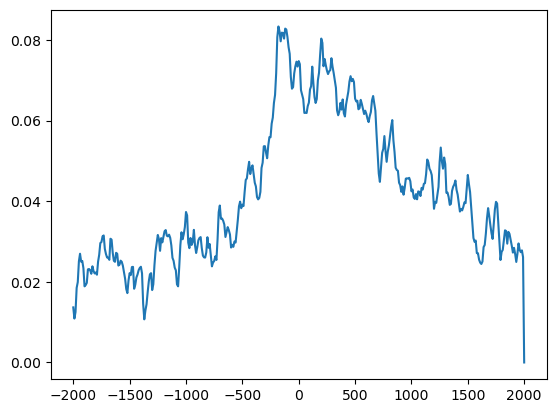

In [63]:
plt.plot(lags, av_across_movies)

In [ ]:
lags[np.argmax(av_across_movies)]

## Shuffled GloVe Embeddings Z-Scoring

In [ ]:
for patient_id in id_eleccount:
    print(patient_id)
    
    chan = 0
    reg_1 = np.load("glove_grav1_reg_" + patient_id + ".npy", allow_pickle=True)
    reg_2 = np.load("glove_grav2_reg_" + patient_id + ".npy", allow_pickle=True)
    
    
    for i in signif_electrode_dict[patient_id]:
        reg_by_channel_1 = np.zeros((1000, 401))
        reg_by_channel_2 = np.zeros((1000, 401))
        
        for j in range(1000):
            # Load shuffled regression values
            reg_by_channel_1[j,:] = np.load("ShuffGloveReg/shuff_glove_g1_reg_" + patient_id + "_" + str(j) + ".npy", allow_pickle=True)[i, :]
            reg_by_channel_2[j,:] = np.load("ShuffGloveReg/shuff_glove_g2_reg_" + patient_id + "_" + str(j) + ".npy", allow_pickle=True)[i, :]
    
        
        # Predictiong Movie 1 using Movie 2
        shuffled_means = np.mean(reg_by_channel_1, axis=0)
        shuffled_stdevs = np.std(reg_by_channel_1, axis=0)
        # Z-Score regression values
        zc_reg = (reg_1[chan, :] - shuffled_means) / shuffled_stdevs
        
        np.save("zc_reg_1_" + patient_id + "_" + str(chan) + ".npy", zc_reg)
        
        # Predictiong Movie 2 using Movie 1
        shuffled_means = np.mean(reg_by_channel_2, axis=0)
        shuffled_stdevs = np.std(reg_by_channel_2, axis=0)
        # Z-Score regression values
        zc_reg = (reg_2[chan, :] - shuffled_means) / shuffled_stdevs
        
        np.save("zc_reg_2_" + patient_id + "_" + str(chan) + ".npy", zc_reg)
        
        chan += 1
        
        

In [202]:
all_sig_elec_vals_1 = np.zeros((43, 401))
all_sig_elec_vals_2 = np.zeros((43, 401))

i = 0
for patient in signif_electrode_dict:
    l = len(signif_electrode_dict[patient])
    for j in range(l):
        all_sig_elec_vals_1[i, :] = np.load("zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        all_sig_elec_vals_2[i, :] = np.load("zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        i += 1

In [203]:
av_across_movies = (np.mean(all_sig_elec_vals_1, axis=0) + np.mean(all_sig_elec_vals_2, axis=0)) / 2

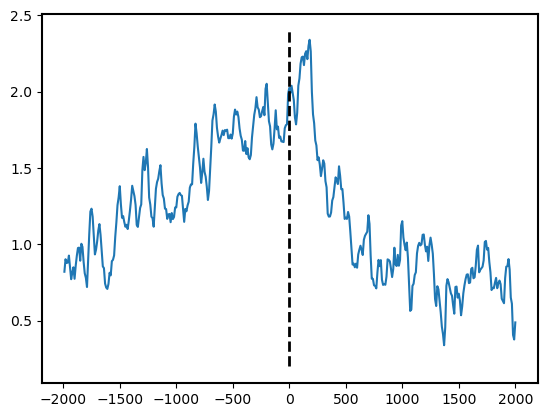

In [204]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5

fig, ax = plt.subplots()
ax.plot(lags*-1, av_across_movies)
ax.patch.set_edgecolor('black') 
ax.vlines(x=0.0, ymin=0.2, ymax=2.4, linewidth=2, color='black', linestyle='dashed')
plt.savefig("glove_zc.png", dpi=600)

In [ ]:
lags[np.argmax(av_across_movies[:-1])]

## T-Test

In [87]:
all_sig_elec_vals_1 = np.zeros((43, 401))
all_sig_elec_vals_2 = np.zeros((43, 401))

i = 0
for patient in signif_electrode_dict:
    l = len(signif_electrode_dict[patient])
    for j in range(l):
        all_sig_elec_vals_1[i, :] = np.load("zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        all_sig_elec_vals_2[i, :] = np.load("zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        i += 1
        
all_movies = (all_sig_elec_vals_1 + all_sig_elec_vals_2) / 2

In [89]:
t_vals = np.zeros(401)
p_vals = np.zeros(401)

# For each patient, average Z-Scores by electrode across the two movies
for i in range(401):
    t_vals[i], p_vals[i] = scipy.stats.ttest_1samp(all_movies[:, i], 0)

In [93]:
# FDR Correct p-values within window of interest:  +/- 2 seconds around 0 lag
fdr_p = mne.stats.fdr_correction(p_vals)

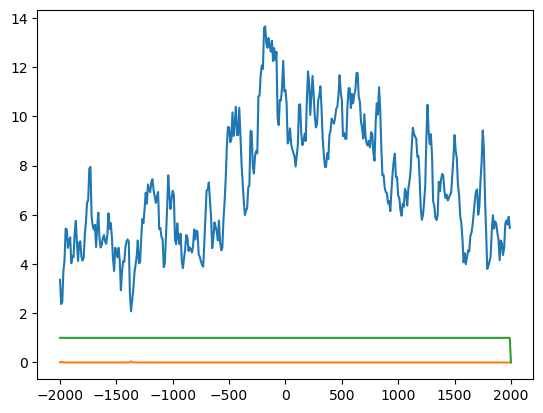

In [94]:
plt.plot(lags, t_vals)
plt.plot(lags, p_vals)
plt.plot(lags, np.ones(401,)*fdr_p[0])

In [158]:
def plot_max_corr_on_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]

        l = len(stat_signif_elec)
        for j in range(l):
            zc_1 = np.load("zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]
            zc_2 = np.load("zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]
            filtered_data.append(np.amax((zc_1 + zc_2) / 2))
            
        filtered_elecpos.append(elecpos[stat_signif_elec, :])

    # Flatten Data
    filtered_elecpos = [item for sublist in filtered_elecpos for item in sublist]

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=2.5,
                    node_vmax=np.max(filtered_data),
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

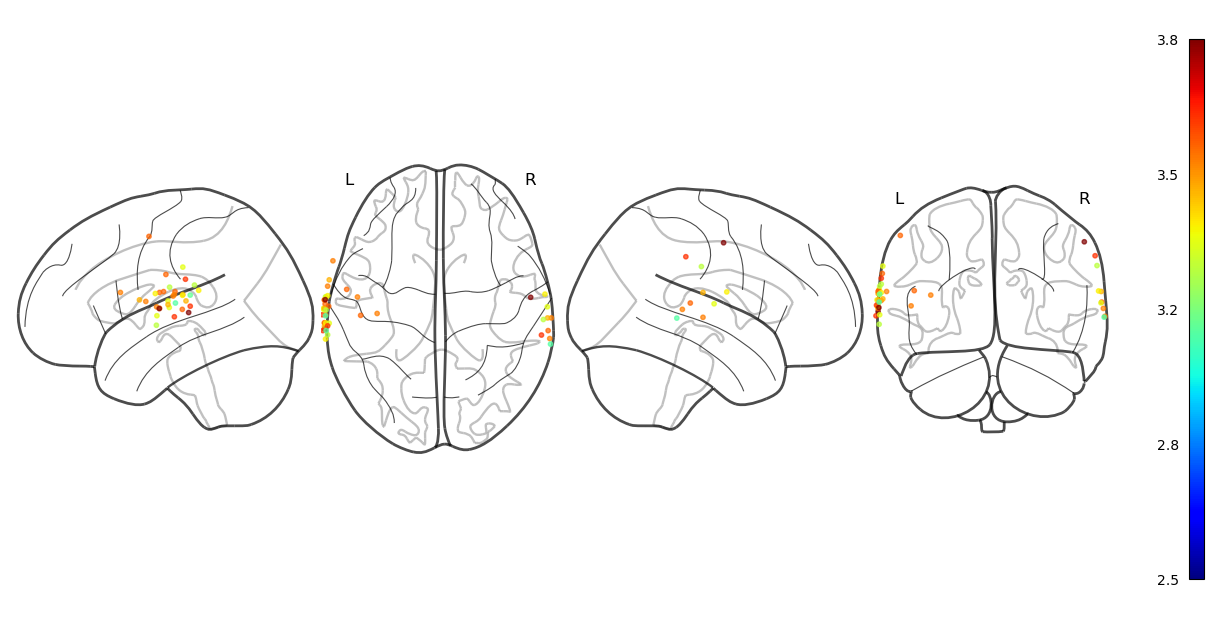

In [159]:
fig = plot_max_corr_on_brain()
plt.savefig("peak_glove_zc.png", dpi=600)

In [170]:
def plot_lag_map_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]

        l = len(stat_signif_elec)
        for j in range(l):
            zc_1 = np.load("zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]
            zc_2 = np.load("zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]

            l = lags[np.argmax((zc_1 + zc_2) / 2)] * -1
            # print(l)
            filtered_data.append(l)
            
        filtered_elecpos.append(elecpos[stat_signif_elec, :])

    # Flatten Data
    filtered_elecpos = [item for sublist in filtered_elecpos for item in sublist]

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=-800,
                    node_vmax=np.max(filtered_data),
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

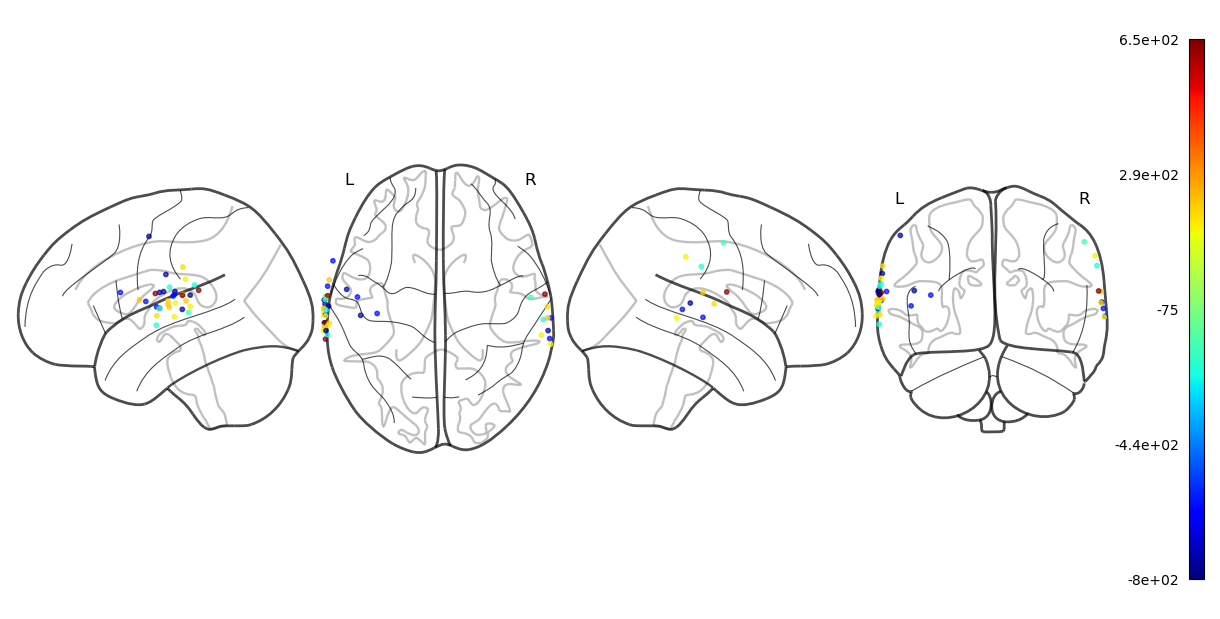

In [171]:
fig = plot_lag_map_brain()
plt.savefig("zc_lag_glove.png", dpi=600)

## GPT-2 Regression

In [ ]:
for patient_id in id_eleccount:
    print(patient_id)
    # Load GPT-2 embeddings
    gpt_1 = np.load("gpt2_emb_1_" + patient_id + ".npy", allow_pickle=True)
    gpt_2 = np.load("gpt2_emb_2_" + patient_id + ".npy", allow_pickle=True)

    # Load downsampled (100 Hz) ECoG Time axis
    ecog1_t = np.load("OnsetData/ds-ecog1-" + patient_id + "-t.npy", allow_pickle = True)
    ecog2_t = np.load("OnsetData/ds-ecog2-" + patient_id + "-t.npy", allow_pickle = True)

    # Load downsampled (100 Hz) ECoG for channels demonstrating sensitivity to word onset
    ecog1 = np.load("OnsetData/tr-ds-ecog1-" + patient_id + ".npy", allow_pickle = True)[signif_electrode_dict[patient_id], :]
    ecog2 = np.load("OnsetData/tr-ds-ecog2-" + patient_id + ".npy", allow_pickle = True)[signif_electrode_dict[patient_id], :]
    
    # Separate word onsets into corresponding ECoG recordings (1 and 2)
    onsets_1 = np.load("gpt2_onsets_1_" + patient_id + ".npy", allow_pickle=True)
    onsets_2 = np.load("gpt2_onsets_2_" + patient_id + ".npy", allow_pickle=True)

    # For each slide of the time window, perform linear regression on sensitive channels
    g1_corrs = np.zeros((ecog1.shape[0], 401))
    g2_corrs = np.zeros((ecog2.shape[0], 401))
    ecog_idxs_1 = get_ecog_idxs(onsets_1, ecog1, ecog1_t)
    ecog_idxs_2 = get_ecog_idxs(onsets_2, ecog2, ecog2_t)
    
    for i in range(-200, 200):
        # Get ECoG values at word onsets
        ecog_at_word_onsets_1 = get_ecog_vals_at_word_onsets(onsets_1, ecog1, ecog_idxs_1, i)
        ecog_at_word_onsets_2 = get_ecog_vals_at_word_onsets(onsets_2, ecog2, ecog_idxs_2, i)
        
        # Predict values for movie 1 using regession coefficients from movie 2 
        for j in range(ecog1.shape[0]):
            g1_corrs[j, i + 200] = reg_pred_ecog_corr(gpt_2, gpt_1, ecog_at_word_onsets_2[:, j], ecog_at_word_onsets_1[:, j]).statistic

        # Predict values for movie 2 using regession coefficients from movie 1
        for j in range(ecog2.shape[0]):
            g2_corrs[j, i + 200] = reg_pred_ecog_corr(gpt_1, gpt_2, ecog_at_word_onsets_1[:, j], ecog_at_word_onsets_2[:, j]).statistic
    
    np.save("gpt_grav1_reg_" + patient_id + ".npy", g1_corrs)
    np.save("gpt_grav2_reg_" + patient_id + ".npy", g2_corrs)            

### Plotting Correlations

In [30]:
all_sig_elec_vals_1 = np.zeros((43, 401))
all_sig_elec_vals_2 = np.zeros((43, 401))

i = 0
for patient in signif_electrode_dict:
    l = len(signif_electrode_dict[patient])
    for j in range(l):
        all_sig_elec_vals_1[i, :] = np.load("gpt_grav1_reg_" + patient + ".npy", allow_pickle=True)[j, :]
        all_sig_elec_vals_2[i, :] = np.load("gpt_grav2_reg_" + patient + ".npy", allow_pickle=True)[j, :]
        i += 1

In [ ]:
av_across_movies = (np.mean(all_sig_elec_vals_1, axis=0) + np.mean(all_sig_elec_vals_2, axis=0)) / 2

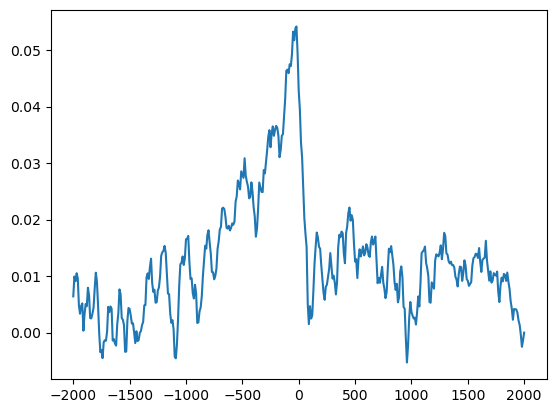

In [31]:
plt.plot(lags, av_across_movies)

# Shuffled GPT-2 Embeddings Z-Scoring

In [ ]:
for patient_id in id_eleccount:
    print(patient_id)
    
    chan = 0
    reg_1 = np.load("gpt_grav1_reg_" + patient_id + ".npy", allow_pickle=True)
    reg_2 = np.load("gpt_grav2_reg_" + patient_id + ".npy", allow_pickle=True)
    
    
    for i in signif_electrode_dict[patient_id]:
        reg_by_channel_1 = np.zeros((1000, 401))
        reg_by_channel_2 = np.zeros((1000, 401))
        
        for j in range(1000):
            # Load shuffled regression values
            reg_by_channel_1[j,:] = np.load("ShuffGPT2Reg/shuff_gpt2_g1_reg_" + patient_id + "_" + str(j) + ".npy", allow_pickle=True)[i, :]
            reg_by_channel_2[j,:] = np.load("ShuffGPT2Reg/shuff_gpt2_g2_reg_" + patient_id + "_" + str(j) + ".npy", allow_pickle=True)[i, :]
    
        
        # Predictiong Movie 1 using Movie 2
        shuffled_means = np.mean(reg_by_channel_1, axis=0)
        shuffled_stdevs = np.std(reg_by_channel_1, axis=0)
        # Z-Score regression values
        zc_reg = (reg_1[chan, :] - shuffled_means) / shuffled_stdevs
        
        np.save("gpt2_zc_reg_1_" + patient_id + "_" + str(chan) + ".npy", zc_reg)
        
        # Predictiong Movie 2 using Movie 1
        shuffled_means = np.mean(reg_by_channel_2, axis=0)
        shuffled_stdevs = np.std(reg_by_channel_2, axis=0)
        # Z-Score regression values
        zc_reg = (reg_2[chan, :] - shuffled_means) / shuffled_stdevs
        
        np.save("gpt2_zc_reg_2_" + patient_id + "_" + str(chan) + ".npy", zc_reg)
        
        chan += 1

In [197]:
all_sig_elec_vals_1 = np.zeros((43, 401))
all_sig_elec_vals_2 = np.zeros((43, 401))

i = 0
for patient in signif_electrode_dict:
    l = len(signif_electrode_dict[patient])
    for j in range(l):
        all_sig_elec_vals_1[i, :] = np.load("gpt2_zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        all_sig_elec_vals_2[i, :] = np.load("gpt2_zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        i += 1

In [198]:
av_across_movies = (np.mean(all_sig_elec_vals_1, axis=0) + np.mean(all_sig_elec_vals_2, axis=0)) / 2

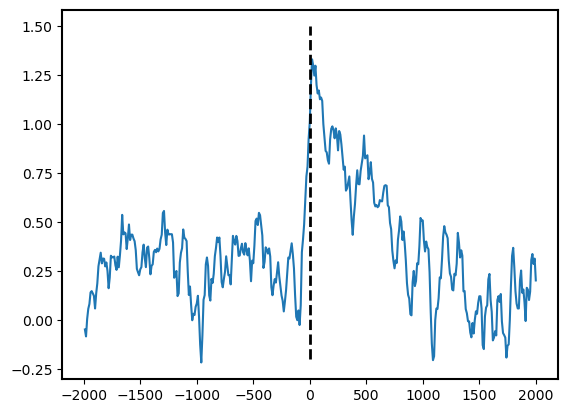

In [201]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5

fig, ax = plt.subplots()
ax.plot(lags*-1, av_across_movies)
ax.patch.set_edgecolor('black') 
ax.vlines(x=0.0, ymin=-0.2, ymax=1.5, linewidth=2, color='black', linestyle='dashed')
plt.savefig("gpt2_zc.png", dpi=600)

In [ ]:
lags[np.argmax(av_across_movies[:-1])]

## T-Test

In [172]:
all_sig_elec_vals_1 = np.zeros((43, 401))
all_sig_elec_vals_2 = np.zeros((43, 401))

i = 0
for patient in signif_electrode_dict:
    l = len(signif_electrode_dict[patient])
    for j in range(l):
        all_sig_elec_vals_1[i, :] = np.load("gpt2_zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        all_sig_elec_vals_2[i, :] = np.load("gpt2_zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)
        i += 1
        
all_movies = (all_sig_elec_vals_1 + all_sig_elec_vals_2) / 2

In [173]:
t_vals = np.zeros(401)
p_vals = np.zeros(401)

# For each patient, average Z-Scores by electrode across the two movies
for i in range(401):
    t_vals[i], p_vals[i] = scipy.stats.ttest_1samp(all_movies[:, i], 0)

In [174]:
# FDR Correct p-values within window of interest:  +/- 2 seconds around 0 lag
fdr_p = mne.stats.fdr_correction(p_vals)

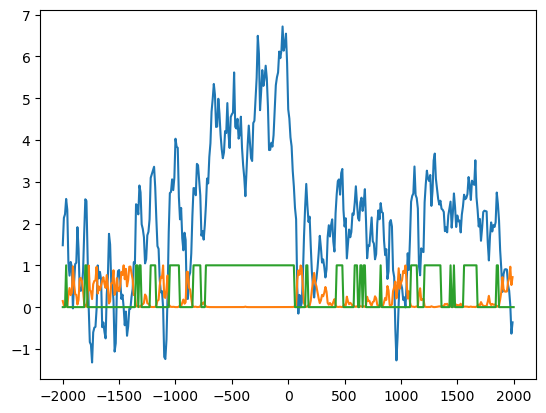

In [175]:
plt.plot(lags, t_vals)
plt.plot(lags, p_vals)
plt.plot(lags, np.ones(401,)*fdr_p[0])

In [184]:
def plot_max_corr_on_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]

        l = len(stat_signif_elec)
        for j in range(l):
            zc_1 = np.load("gpt2_zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]
            zc_2 = np.load("gpt2_zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]
            filtered_data.append(np.amax((zc_1 + zc_2) / 2))
            
        filtered_elecpos.append(elecpos[stat_signif_elec, :])

    # Flatten Data
    filtered_elecpos = [item for sublist in filtered_elecpos for item in sublist]

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=np.min(filtered_data),
                    node_vmax=np.max(filtered_data),
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

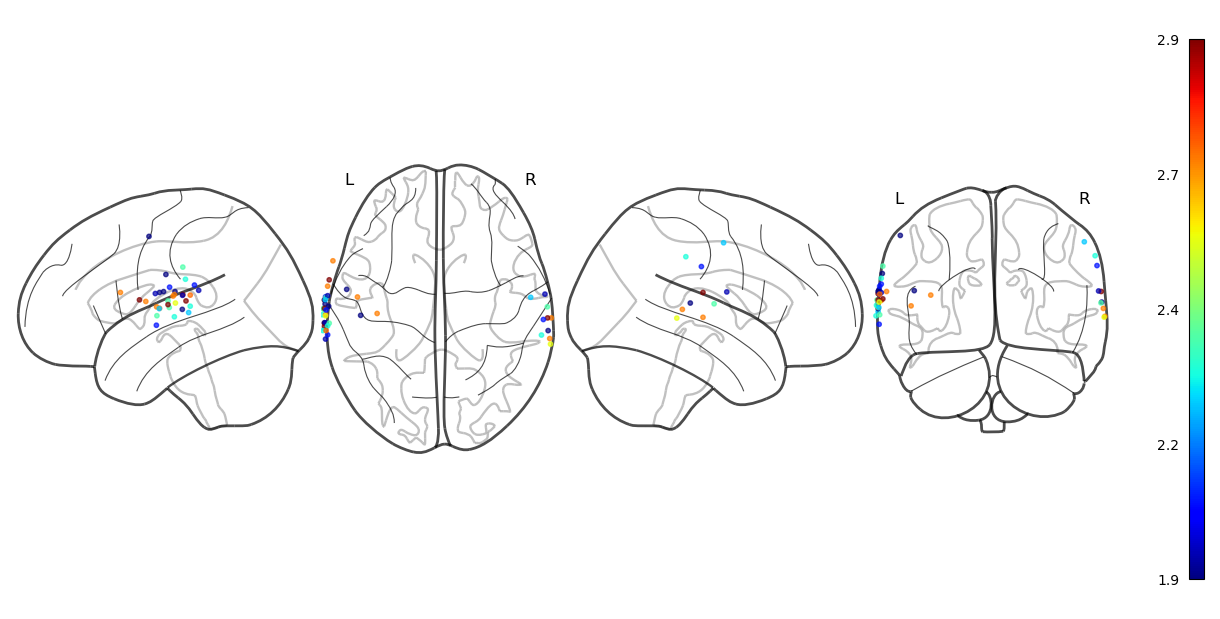

In [185]:
fig = plot_max_corr_on_brain()
plt.savefig("peak_gpt2_zc.png", dpi=600)

In [186]:
def plot_lag_map_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]

        l = len(stat_signif_elec)
        for j in range(l):
            zc_1 = np.load("gpt2_zc_reg_1_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]
            zc_2 = np.load("gpt2_zc_reg_2_" + patient + "_" + str(j) + ".npy", allow_pickle=True)[:-1]

            l = lags[np.argmax((zc_1 + zc_2) / 2)] * -1
            # print(l)
            filtered_data.append(l)
            
        filtered_elecpos.append(elecpos[stat_signif_elec, :])

    # Flatten Data
    filtered_elecpos = [item for sublist in filtered_elecpos for item in sublist]

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=-800,
                    node_vmax=np.max(filtered_data),
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

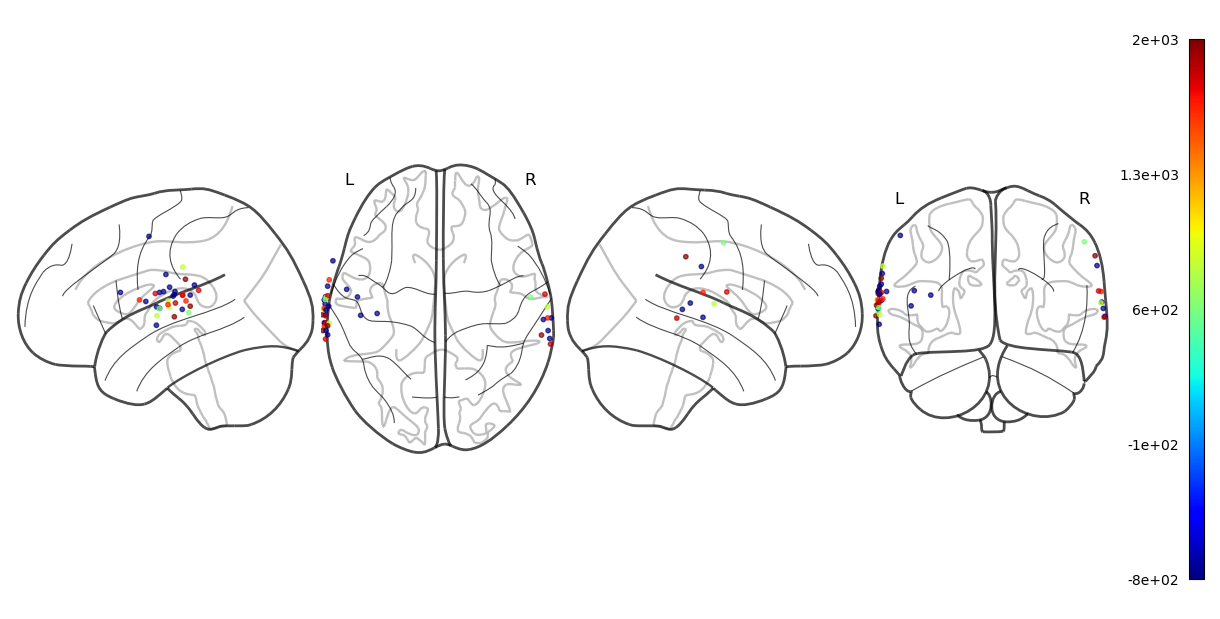

In [187]:
fig = plot_lag_map_brain()
plt.savefig("zc_lag_gpt.png", dpi=600)